# Block 6 Exercise 2: finding the best parameters for predicting the fare of taxi rides
We return to our Random Forest Regression and want to automatically optimize all free parameters ...

In [1]:
!pip install folium
!pip install scikit-optimize

     |████████████████████████████████| 94 kB 4.5 MB/s eta 0:00:011
     |████████████████████████████████| 101 kB 4.8 MB/s ta 0:00:011


In [2]:
import pandas as pd
import numpy as np
import folium


In [3]:
# we load the data we have saved after wrangling and pre-processing in block I
X=pd.read_csv('../../DATA/train_cleaned.csv')
drop_columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1','key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']
X=X.drop(drop_columns,axis=1)
X=pd.get_dummies(X)# one hot coding
#generate labels
y=X['fare_amount']
X=X.drop(['fare_amount'],axis=1)

### Scikit Optimize
Scikit Optimize (https://scikit-optimize.github.io/stable/index.html) is a AutoML toolbox wrapped around Scikit-Learn. It allows us to use state-of-the-art automatic hyper-parameter optimization on top of our learning algorithms.   



In [4]:
# install, in cell 1 already installed
#!pip install scikit-optimize

### E 2.1 Bayesian Optimization of a Random Forest Regression Model
use Bayesian Optimization with Cross-Validation (https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html#skopt.BayesSearchCV) to find the best regression model. Compare
* linear regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression) 
* Random Forest regression (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor)
* and SVM regression (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)

NOTES: this can become quite compute intensive! Hence,
* use a smaller subset of the training data to run the experiments 
* think about the range of your parameters (e.g. larger number of trees in RF or high C-values in SMV will make models expensive)
* optimize only the following parameters per model type:
    * linear: no parameters to optimize
    * RF: #trees and depth
    * SVM: C and gamma (use RBF kernel)
* parallelize -> n_jobs
* use CoLab to rum the job for up to 12h 


In [41]:
from skopt import BayesSearchCV as BSCV
from skopt.space.space import Integer as skopt_int
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR 
from sklearn.metrics import mean_squared_error as mse
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [6]:
np.shape(X)

(400000, 31)

In [7]:
y_less = y[:10000]
X_less=X[:10000]
print(np.shape(X_less), np.shape(y_less))

(10000, 31) (10000,)


In [8]:
X_l_train,X_l_test,y_l_train,y_l_test = train_test_split(X_less,y_less, test_size=0.1, random_state = 1)

In [9]:
print(type(y_l_train), type(y_l_test))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>


### ***Linear regression***
- There are no parameters to be optimzied. So no BayesSearchCV is used

In [10]:
LRm = LR().fit(X_l_train,y_l_train)

In [11]:
res_LR_y_l_test = LRm.predict(X_l_test)

In [12]:
mse_LR_test = mse(y_l_test,res_LR_y_l_test)
mse_LR_test

25.88405237662758

### ***Random Forest Tree***

In [13]:
RFR_pl = make_pipeline(StandardScaler(),RFR(random_state = 0))

In [14]:
RFR_pl.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'randomforestregressor', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'randomforestregressor__bootstrap', 'randomforestregressor__ccp_alpha', 'randomforestregressor__criterion', 'randomforestregressor__max_depth', 'randomforestregressor__max_features', 'randomforestregressor__max_leaf_nodes', 'randomforestregressor__max_samples', 'randomforestregressor__min_impurity_decrease', 'randomforestregressor__min_impurity_split', 'randomforestregressor__min_samples_leaf', 'randomforestregressor__min_samples_split', 'randomforestregressor__min_weight_fraction_leaf', 'randomforestregressor__n_estimators', 'randomforestregressor__n_jobs', 'randomforestregressor__oob_score', 'randomforestregressor__random_state', 'randomforestregressor__verbose', 'randomforestregressor__warm_start'])

In [15]:
search_spaces = {'randomforestregressor__n_estimators': skopt_int(1,1000),
                  'randomforestregressor__max_depth' : skopt_int(2,100)}

In [16]:
RFR_BSCV = BSCV(estimator = RFR_pl, search_spaces = search_spaces, n_iter=50,n_jobs=-1,random_state=0)

In [17]:
RFR_BSCV.fit(X_l_train,y_l_train)

/home/student/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/student/anaconda3/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/home/student/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


BayesSearchCV(cv=None, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('standardscaler',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('randomforestregressor',
                                         RandomForestRegressor(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               criterion='mse',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
                                                               max_samples=None,
        

In [18]:
RFR_BSCV.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=27,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=979, n_jobs=None,
                                       oob_score=False, random_state=0,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [19]:
#RFR_BSCV.cv_results_

In [20]:
RFR_BSCV.best_estimator_.get_params()['randomforestregressor']

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=27, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=979, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [21]:
RFR_BSCV.best_score_

0.7770711533761413

n_iter=30,
best_estimator_params,
- max_depth = 27
- n_estimators = 979
- best_score_ = 0.77707

n_iter=50,
best_estimator_params,
- max_depth = 27
- n_estimators = 979
- best_score_ = 0.77707


### ***SVM***

In [22]:
from skopt.space.space import Categorical as skopt_cat
from skopt.space.space import Real as skopt_real

In [23]:
SVR_pl = make_pipeline(StandardScaler(),SVR(kernel='rbf'))

In [24]:
SVR_pl.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'standardscaler', 'svr', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'svr__C', 'svr__cache_size', 'svr__coef0', 'svr__degree', 'svr__epsilon', 'svr__gamma', 'svr__kernel', 'svr__max_iter', 'svr__shrinking', 'svr__tol', 'svr__verbose'])

In [25]:
search_spaces = {'svr__gamma': skopt_cat(['scale','auto']),
                  'svr__C' : skopt_real(0.01,100)}

In [26]:
SVR_BSCV = BSCV(estimator = SVR_pl, search_spaces = search_spaces, n_iter=50,n_jobs=-1,random_state=0)

In [27]:
SVR_BSCV.fit(X_l_train,y_l_train)

BayesSearchCV(cv=None, error_score='raise',
              estimator=Pipeline(memory=None,
                                 steps=[('standardscaler',
                                         StandardScaler(copy=True,
                                                        with_mean=True,
                                                        with_std=True)),
                                        ('svr',
                                         SVR(C=1.0, cache_size=200, coef0=0.0,
                                             degree=3, epsilon=0.1,
                                             gamma='scale', kernel='rbf',
                                             max_iter=-1, shrinking=True,
                                             tol=0.001, verbose=False))],
                                 verbose=False),
              fit_params=None, iid=True, n_iter=50, n_jobs=-1, n_points=1,
              optimizer_kwargs=None, pre_dispatch='2*n_jobs', random_state=0,
              refit=

In [28]:
SVR_BSCV.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=26.836640050057976, cache_size=200, coef0=0.0, degree=3,
                     epsilon=0.1, gamma='auto', kernel='rbf', max_iter=-1,
                     shrinking=True, tol=0.001, verbose=False))],
         verbose=False)

In [55]:
SVR_BSCV.best_params_

OrderedDict([('svr__C', 26.836640050057976), ('svr__gamma', 'auto')])

In [29]:
#SVR_BSCV.cv_results_

In [30]:
#SVR_BSCV.best_estimator_.get_params()['??']

In [31]:
SVR_BSCV.best_score_

0.786871206486285

n_iter=50,
best_estimator_params,
- gamma= 'auto'
- C = 26.8366
- best score = 0.78687

In [32]:
res_y_l_test = SVR_BSCV.best_estimator_.predict(X_l_test)

In [33]:
diff_y_l_test = res_y_l_test - y_l_test

In [36]:
np.std(diff_y_l_test)

3.4722005297237732

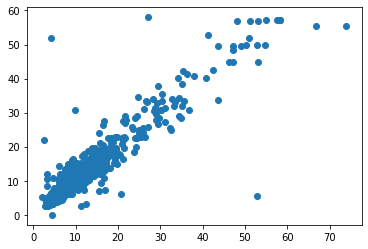

In [42]:
plt.scatter(res_y_l_test,y_l_test)

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   2.,   2.,   3.,   6.,  10.,
         17.,  14.,  28.,  53., 110., 192., 271., 176.,  58.,  21.,   9.,
          6.,   2.,   3.,   2.,   3.,   2.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-47.70737576, -46.75686108, -45.80634641, -44.85583174,
        -43.90531707, -42.95480239, -42.00428772, -41.05377305,
        -40.10325838, -39.1527437 , -38.20222903, -37.25171436,
        -36.30119969, -35.35068501, -34.40017034, -33.44965567,
        -32.49914099, -31.54862632, -30.59811165, -29.64759698

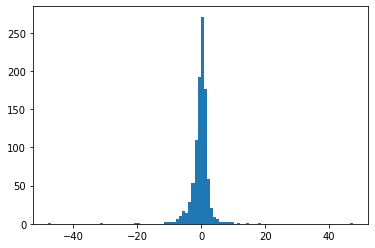

In [44]:
plt.hist(diff_y_l_test,bins=100)

In [45]:
outlier_mask = abs(diff_y_l_test) > 5

In [46]:
outlier = X_l_test[outlier_mask]

In [52]:
outlier.iloc[0,1]

40.702744

In [53]:
#Plot all high error predictions
error_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
for i in range(np.shape(outlier)[0]):
    folium.CircleMarker([outlier.iloc[i,1], outlier.iloc[i,0]], radius=3,                
                        color="green", 
                        fill_opacity=0.9
                       ).add_to(error_map)
    folium.CircleMarker([outlier.iloc[i,3], outlier.iloc[i,2]], radius=3,                
                        color="red", 
                        fill_opacity=0.9
                       ).add_to(error_map)
    folium.PolyLine([ [outlier.iloc[i,1],outlier.iloc[i,0]] , [outlier.iloc[i,3],outlier.iloc[i,2]]  ], color="black", weight=2.5, opacity=1).add_to(error_map)

In [54]:
error_map

Bei den Ausreißern scheint es sich überwiegend um längere Fahrten zu handeln.